In [1]:
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from gt_map import GTMap
gt_map_file = '/home/kirill/TopoSLAM/GT/2n8kARJN3HM/map_cropped_0_600_300_900.png'
gt_map = GTMap(gt_map_file)
gt_map_image = imread(gt_map_file)

In [15]:
import json
fin = open('/home/kirill/TopoSLAM/toposlam_ws/src/simple_toposlam_model/graph_jsons_new/2n8kARJN3HM_0.25.json')
j = json.load(fin)
fin.close()
vertices = j['vertices']
edges = j['edges']

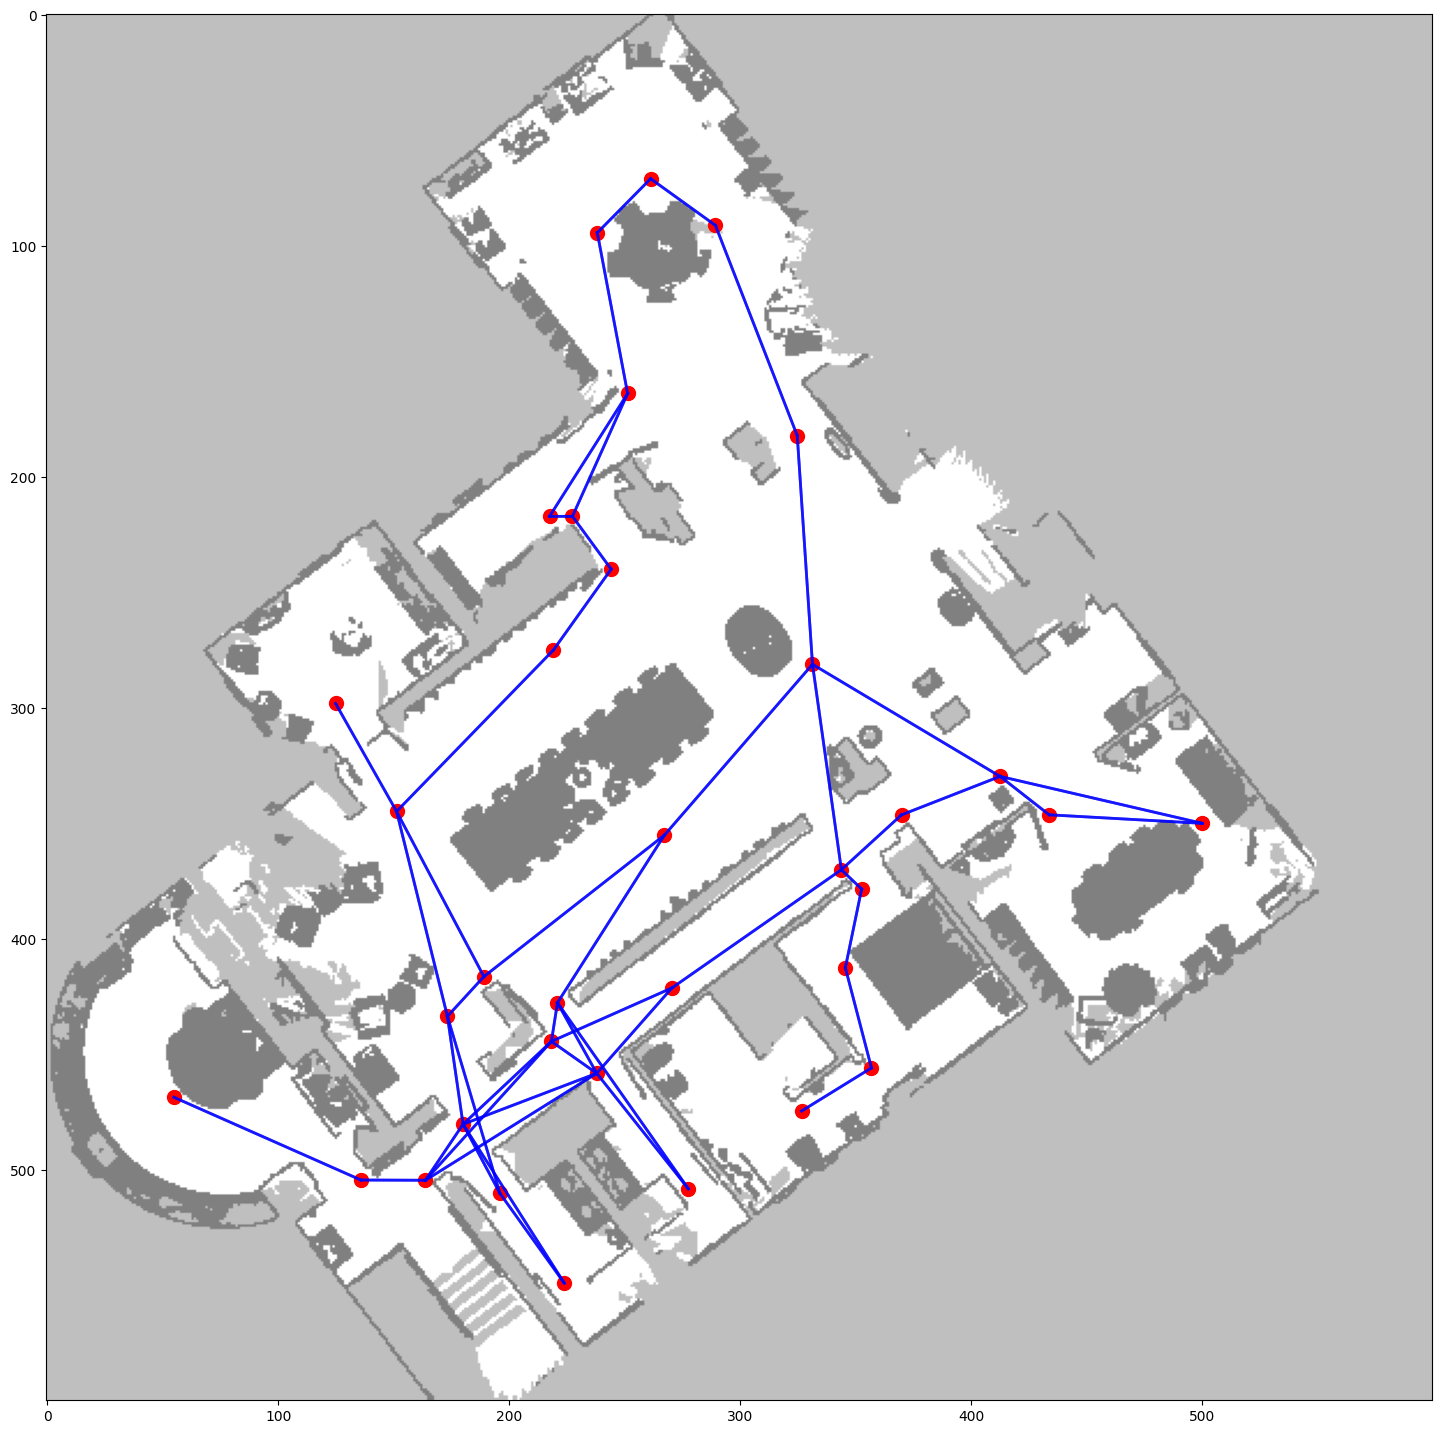

In [16]:
plt.figure(figsize=(18, 18))
plt.imshow(gt_map_image, cmap='gray', alpha=0.5)
for x, y, theta in vertices:
    i = y * 20 + 480
    j = x * 20 + 180
    plt.scatter([j], [i], color='r', s=100)
for u in range(len(edges)):
    for v in edges[u]:
        x1, y1, theta = vertices[u]
        x2, y2, theta = vertices[v]
        i1 = y1 * 20 + 480
        j1 = x1 * 20 + 180
        i2 = y2 * 20 + 480
        j2 = x2 * 20 + 180
        plt.plot([j1, j2], [i1, i2], color='b', lw=2, alpha=0.7)
plt.savefig('simple_toposlam_model_graph.png')

In [6]:
cur_grid = np.loadtxt('../../iou/cur_grid.txt')
cur_grid_transformed = np.loadtxt('../../iou/cur_grid_transformed.txt')
v_grid = np.loadtxt('../../iou/v_grid.txt')
poses = np.loadtxt('../../iou/poses.txt')

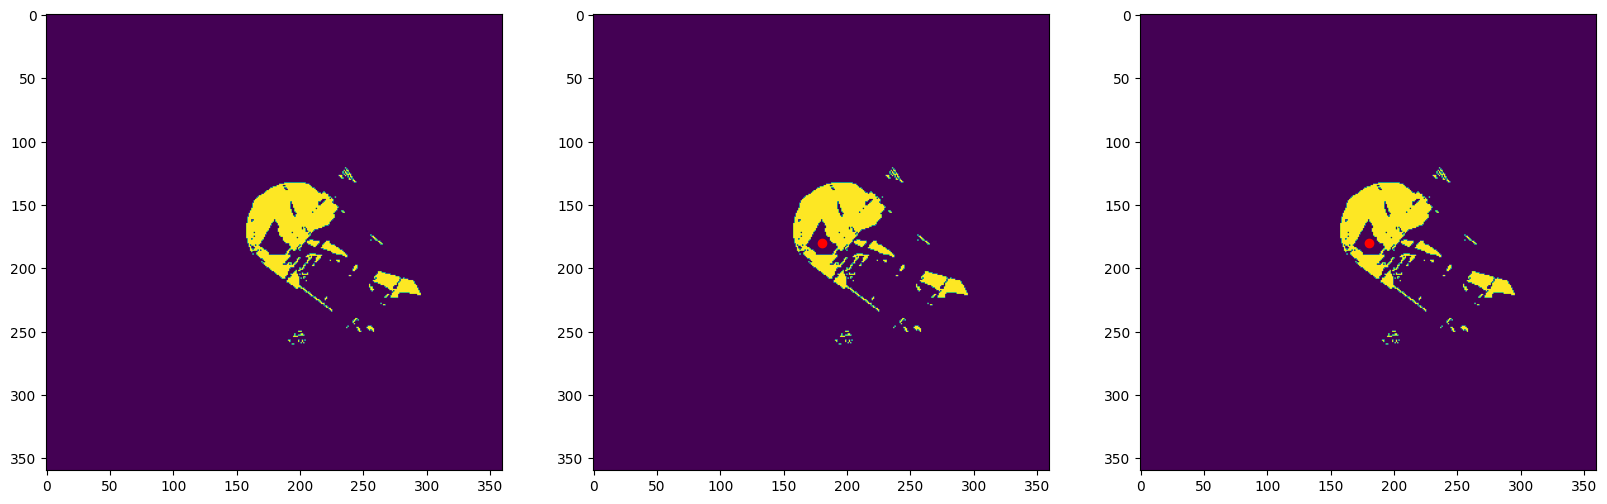

In [7]:
plt.figure(figsize=(20, 7))
plt.subplot(1, 3, 1)
plt.imshow(cur_grid)
plt.subplot(1, 3, 2)
plt.imshow(cur_grid_transformed)
plt.scatter([180], [180], color='r')
plt.subplot(1, 3, 3)
plt.imshow(v_grid)
plt.scatter([180], [180], color='r')

In [8]:
from skimage.transform import rotate

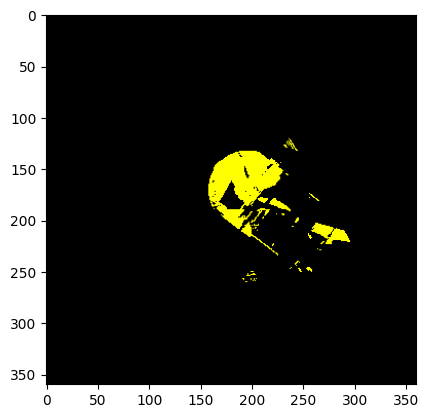

In [9]:
grid_multi = np.zeros((v_grid.shape[0], v_grid.shape[1], 3))
grid_multi[:, :, 0] = cur_grid_transformed
#grid_multi[:, 12:, 0] = rotate(cur_grid_transformed, 0)[:, :-12]
grid_multi[:, :, 1] = v_grid
plt.imshow(grid_multi)

In [10]:
print(poses)

[-6.72699547 -2.50825763 -1.5707922  -6.72699547 -2.50825763 -1.5707922
  0.          0.          0.        ]


In [11]:
cur_grids = np.load('grids/cur_grids.npz')['arr_0']
cur_grids_transformed = np.load('grids/cur_grids_transformed.npz')['arr_0']
ref_grids = np.load('grids/ref_grids.npz')['arr_0']
pose_pairs = np.loadtxt('grids/poses.txt')

In [12]:
def normalize(angle):
    while angle < -np.pi:
        angle += 2 * np.pi
    while angle > np.pi:
        angle -= 2 * np.pi
    return angle

def rotate(x, y, angle):
    x_new = x * np.cos(angle) + y * np.sin(angle)
    y_new = -x * np.sin(angle) + y * np.cos(angle)
    return x_new, y_new

def get_rel_pose(x, y, theta, x2, y2, theta2):
    angle = normalize(np.arctan2(y2 - y, x2 - x) - theta)
    rel_x, rel_y = rotate(x2 - x, y2 - y, theta2)#angle + np.pi / 2)
    #rel_x, rel_y = x2 - x, y2 - y
    return rel_x, rel_y, theta2 - theta

get_rel_pose(*pose_pairs[i, :6])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
def transform_grid(grid, x, y, theta):
    points = np.array(grid.nonzero()).T - [180, 180]
    points_transformed = points.copy().astype(np.float32)
    points_transformed[:, 0] = points[:, 0] * np.cos(theta) + points[:, 1] * np.sin(theta)
    points_transformed[:, 1] = -points[:, 0] * np.sin(theta) + points[:, 1] * np.cos(theta)
    points_transformed[:, 0] -= x * 10
    points_transformed[:, 1] -= y * 10
    points_transformed = points_transformed.astype(int) + [180, 180]
    points_transformed[:, 0] = np.clip(points_transformed[:, 0], 0, grid.shape[0])
    points_transformed[:, 1] = np.clip(points_transformed[:, 1], 0, grid.shape[1])
    grid_transformed = np.zeros_like(grid)
    grid_transformed[points_transformed[:, 0], points_transformed[:, 1]] = 1
    return grid_transformed

In [ ]:
for i in range(0, cur_grids.shape[0], 10):
    #rel_x, rel_y, rel_theta = get_rel_pose(*pose_pairs[i, :6])
    #cur_grid_transformed = transform_grid(cur_grids[i], rel_x, rel_y, rel_theta)
    grid_multi = np.zeros((cur_grids.shape[1], cur_grids.shape[2], 3))
    #grid_multi[:, :, 0] = cur_grid_transformed
    grid_multi[:, :, 0] = cur_grids_transformed[i]
    grid_multi[:, :, 1] = ref_grids[i]
    intersection = np.sum(grid_multi[:, :, 0] * grid_multi[:, :, 1])
    union = np.sum(np.maximum(grid_multi[:, :, 0], grid_multi[:, :, 1]))
    plt.title('IoU: {}'.format(np.round(intersection / union, 3)), fontsize=18)
    plt.imshow(grid_multi)
    plt.show()